## ___Feature Scaling___
------------------------

In [2]:
import numpy as np
np.random.seed(2024 - 5 - 14)
import pandas as pd
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 100)

from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from scipy.stats import pearsonr

import matplotlib.pyplot as plt

In [3]:
# this dataset is actually curated for a classification problem, but anyways,

beans = pd.read_csv(r"./drybeans.csv")

In [4]:
beans.columns

Index(['Area', 'Perimeter', 'MajorAxisLength', 'MinorAxisLength',
       'AspectRation', 'Eccentricity', 'ConvexArea', 'EquivDiameter', 'Extent',
       'Solidity', 'roundness', 'Compactness', 'ShapeFactor1', 'ShapeFactor2',
       'ShapeFactor3', 'ShapeFactor4', 'Class'],
      dtype='object')

In [5]:
# we'll be using it for multiple linear regression yikes!

beans.Class.unique()

array(['SEKER', 'BARBUNYA', 'BOMBAY', 'CALI', 'HOROZ', 'SIRA', 'DERMASON'],
      dtype=object)

In [6]:
# let's say that our target variable is the Area! (a classification problem)
y = beans.Area
x = beans.iloc[:, 1:-1]

In [7]:
# see the variations in the ranges of values that make up the predictors!

x.apply([np.max, np.min]).T

,max,min
Perimeter,1985.370000,524.736000
MajorAxisLength,738.860153,183.601165
MinorAxisLength,460.198497,122.512653
AspectRation,2.430306,1.024868
Eccentricity,0.911423,0.218951
ConvexArea,263261.000000,20684.000000
EquivDiameter,569.374358,161.243764
Extent,0.866195,0.555315
Solidity,0.994677,0.919246
roundness,0.990685,0.489618


In [8]:
# and we have this many predictors

x.columns.size

15

In [9]:
# depending on the influence of each predictor on the target variable, the machine learning algorithm will infer the weights for these predictor 
# variables.
# if the range of values in these predictors vary greatly in between themselves,
# variation within predictors is unavoidable and in fact essential in machine learning.
# but different predictors having very different ranges can affect the learning algorithm negatively!

In [10]:
# e.g. this is the range of the roundedness predictor in our dataset

x.roundness.min(), x.roundness.max()

(0.489618256241215, 0.990685399616032)

In [11]:
# these are the ranges of the area variable in our training dataset!

x.Perimeter.min(), x.Perimeter.max()

(524.736, 1985.37)

In [12]:
# as you see these is a large difference in the ranges of these two predictors
# in such cases where the upper and lower limits ofpredictors vary greatly, the coefficents used to bootstrap the algorithm can be very different 
# from the actual ones.
# eg the weight for roundedness is bootstrapped to be 3412, and the real coefficient is 1785
# even with relatively big learning rates, the gradient descent will have to iterate numerous times before finding the local minimum with
# respect to the given predictor (roundedness) :: smaller ranged predictor - larger coefficients (!usually)
# and this needs to happen for all the predictors, the more predictors with larger ranges, the more inefficient gradient descent will be.

# the reason is that with an alpha = 0.1, and a bootstrap value 1785 for the weight of a predictor with ranges 0.489618256241215 and 0.990685399616032
# the algorithm will have to iterate so many times to get to the local minimum
# assume that the real coefficent is somewhere around 1546

ALPHA = 0.1
niters = np.abs(1546 - 1785) / ALPHA
niters

2390.0

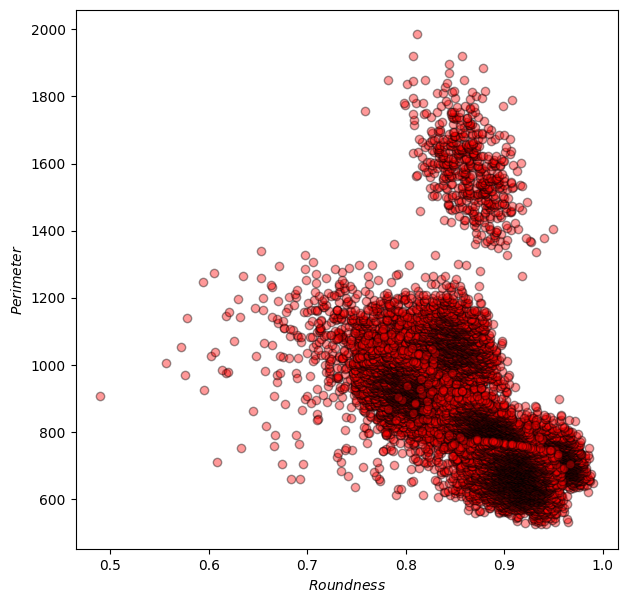

In [13]:
# to further illustrate this point,

fig, axes = plt.subplots()
fig.set_size_inches(7, 7)
axes.scatter(x.roundness, x.Perimeter, c = "red", edgecolor = "black", alpha = 0.4)
axes.set_xlabel("$Roundness$")
axes.set_ylabel("$Perimeter$")
plt.show()

In [14]:
# look at the scales of the x and y axis,

axes.get_xlim(), axes.get_ylim()

((0.46456489907247417, 1.0157387567847729), (451.7043, 2058.4017))

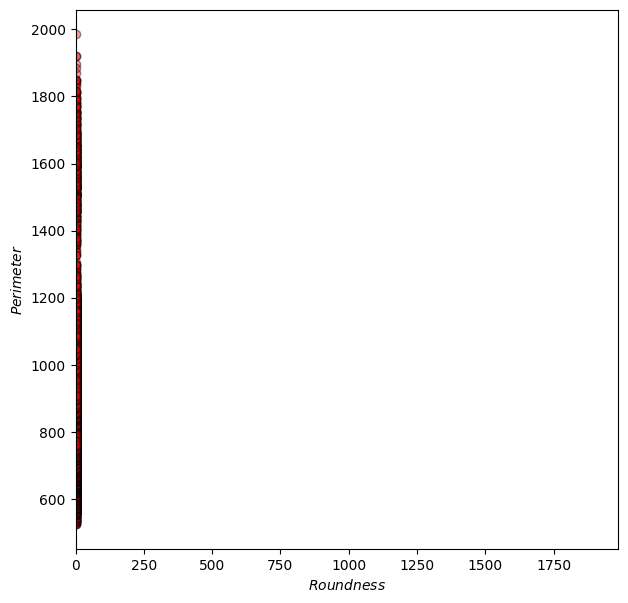

In [15]:
# if we use the same axis

fig, axes = plt.subplots()
fig.set_size_inches(7, 7)
axes.scatter(x.roundness, x.Perimeter, c = "red", edgecolor = "black", alpha = 0.4)
axes.set_xlim(0, x.Perimeter.max())
axes.set_xlabel("$Roundness$")
axes.set_ylabel("$Perimeter$")
plt.show()

In [16]:
# when the same scales are used for x and y axes, we cannot even see the points separately!
# we need to minimize this!

In [17]:
# the dataset is quite small!

x.shape

(13611, 15)

In [18]:
mmscaler = MinMaxScaler()
stdscaler = StandardScaler()

In [19]:
scaled_x = mmscaler.fit_transform(x)

In [20]:
scaled_x.shape

(13611, 15)

In [21]:
# this is what happens when the data is scaled!

scaled_x.min(), scaled_x.max()

(0.0, 1.0000000000000002)

In [22]:
train_scaled_x, test_scaled_x, train_y, test_y = train_test_split(scaled_x, y, test_size = 0.3)
train_x, test_x, _train_y, _test_y = train_test_split(x, y, test_size = 0.3)

train_scaled_x.shape, test_scaled_x.shape, train_y.shape, test_y.shape, train_x.shape, test_x.shape, _train_y.shape, _test_y.shape

((9527, 15),
 (4084, 15),
 (9527,),
 (4084,),
 (9527, 15),
 (4084, 15),
 (9527,),
 (4084,))

In [23]:
linreg = LinearRegression(n_jobs = 16)

In [24]:
%%timeit
# see how much time it takes to gradient descent usig the scaled training data

linreg.fit(train_scaled_x, train_y)

2.69 ms ± 268 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [25]:
# look at that!

{feature: coef for (feature, coef) in zip(x.columns, linreg.coef_)}

{'Perimeter': -19471.260719966813,
 'MajorAxisLength': -99119.25678568488,
 'MinorAxisLength': -111633.9429843211,
 'AspectRation': 15360.558254788271,
 'Eccentricity': 2091.0482241652817,
 'ConvexArea': 232991.2994980064,
 'EquivDiameter': 226739.84601722177,
 'Extent': 1.5955816875640427,
 'Solidity': 5046.383346480587,
 'roundness': -4044.1753462977586,
 'Compactness': 14233.878425117258,
 'ShapeFactor1': 5061.362585294948,
 'ShapeFactor2': -2951.9176633243483,
 'ShapeFactor3': 10935.791943988446,
 'ShapeFactor4': -4759.640331919351}

In [26]:
# that's pretty amazing :)

pearsonr(linreg.predict(test_scaled_x), test_y)

PearsonRResult(statistic=0.9999938841436844, pvalue=0.0)

In [27]:
%%timeit
# see how much time it takes to gradient descent usig the raw training data

linreg.fit(train_x, _train_y)

3.59 ms ± 347 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [28]:
{feature: coef for (feature, coef) in zip(x.columns, linreg.coef_)}

{'Perimeter': -13.285793116824248,
 'MajorAxisLength': -188.05117880372953,
 'MinorAxisLength': -339.6408575660429,
 'AspectRation': 11563.17606065103,
 'Eccentricity': 2967.648954533984,
 'ConvexArea': 0.9609757356468042,
 'EquivDiameter': 574.2626542714006,
 'Extent': 43.13433352276997,
 'Solidity': 67375.78333874386,
 'roundness': -8119.991091449895,
 'Compactness': 42693.806767003356,
 'ShapeFactor1': 613172.642417934,
 'ShapeFactor2': -794142.5318324651,
 'ShapeFactor3': 18101.420039661738,
 'ShapeFactor4': -94646.16248735838}

In [29]:
# wow! it looks scaled training set took a little less time than the raw dataset!

pearsonr(linreg.predict(test_x), _test_y)

PearsonRResult(statistic=0.9999947845623097, pvalue=0.0)

In [30]:
scaled_x = stdscaler.fit_transform(x)

train_scaled_x, test_scaled_x, train_y, test_y = train_test_split(scaled_x, y, test_size = 0.3)
train_x, test_x, _train_y, _test_y = train_test_split(x, y, test_size = 0.3)
linreg = LinearRegression(n_jobs = 16)

# raw data
linreg.fit(train_x, _train_y)
print(f"Raw, unprocessed data :: {pearsonr(linreg.predict(test_x), _test_y)}")

# scaled data
linreg.fit(train_scaled_x, train_y)
print(f"Scaled data :: {pearsonr(linreg.predict(test_scaled_x), test_y)}")

Raw, unprocessed data :: PearsonRResult(statistic=0.9999944469787172, pvalue=0.0)
Scaled data :: PearsonRResult(statistic=0.9999933351161604, pvalue=0.0)


# ___Ames,Iowa housing datset___
------------------

In [31]:
ames = pd.read_csv(r"./ames_house_prices.csv", na_values = '?', index_col = 0).reset_index().drop("Id", axis = 1)

In [32]:
# YIKES!

for column, naperc in zip(ames.columns, ames.isna().mean(axis = 0)):
    if not np.isclose(naperc, 0.000000):
        print(f"{column:20s} :: {naperc:.5f}")

LotFrontage          :: 0.17740
Alley                :: 0.93767
MasVnrType           :: 0.59726
MasVnrArea           :: 0.00548
BsmtQual             :: 0.02534
BsmtCond             :: 0.02534
BsmtExposure         :: 0.02603
BsmtFinType1         :: 0.02534
BsmtFinType2         :: 0.02603
Electrical           :: 0.00068
FireplaceQu          :: 0.47260
GarageType           :: 0.05548
GarageYrBlt          :: 0.05548
GarageFinish         :: 0.05548
GarageQual           :: 0.05548
GarageCond           :: 0.05548
PoolQC               :: 0.99521
Fence                :: 0.80753
MiscFeature          :: 0.96301


In [33]:
# get rid of the NAs

ames.dropna(axis = 1, inplace = True)

In [34]:
for (column, _type) in zip(ames.columns, ames.dtypes):
    print(f"{column:20s} :: {_type}")

MSSubClass           :: int64
MSZoning             :: object
LotArea              :: int64
Street               :: object
LotShape             :: object
LandContour          :: object
Utilities            :: object
LotConfig            :: object
LandSlope            :: object
Neighborhood         :: object
Condition1           :: object
Condition2           :: object
BldgType             :: object
HouseStyle           :: object
OverallQual          :: int64
OverallCond          :: int64
YearBuilt            :: int64
YearRemodAdd         :: int64
RoofStyle            :: object
RoofMatl             :: object
Exterior1st          :: object
Exterior2nd          :: object
ExterQual            :: object
ExterCond            :: object
Foundation           :: object
BsmtFinSF1           :: int64
BsmtFinSF2           :: int64
BsmtUnfSF            :: int64
TotalBsmtSF          :: int64
Heating              :: object
HeatingQC            :: object
CentralAir           :: object
1stFlrSF          

In [35]:
# feature engineering

In [36]:
# categoricals

[column for (column, _type) in zip(ames.columns, ames.dtypes) if _type == object]

['MSZoning',
 'Street',
 'LotShape',
 'LandContour',
 'Utilities',
 'LotConfig',
 'LandSlope',
 'Neighborhood',
 'Condition1',
 'Condition2',
 'BldgType',
 'HouseStyle',
 'RoofStyle',
 'RoofMatl',
 'Exterior1st',
 'Exterior2nd',
 'ExterQual',
 'ExterCond',
 'Foundation',
 'Heating',
 'HeatingQC',
 'CentralAir',
 'KitchenQual',
 'Functional',
 'PavedDrive',
 'SaleType',
 'SaleCondition']

In [37]:
# numericals

[column for (column, _type) in zip(ames.columns, ames.dtypes) if _type != object]

['MSSubClass',
 'LotArea',
 'OverallQual',
 'OverallCond',
 'YearBuilt',
 'YearRemodAdd',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 '1stFlrSF',
 '2ndFlrSF',
 'LowQualFinSF',
 'GrLivArea',
 'BsmtFullBath',
 'BsmtHalfBath',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'TotRmsAbvGrd',
 'Fireplaces',
 'GarageCars',
 'GarageArea',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 '3SsnPorch',
 'ScreenPorch',
 'PoolArea',
 'MiscVal',
 'MoSold',
 'YrSold',
 'SalePrice']

In [38]:
# transform the categoricals into numericals

ames_copy = ames.copy()
encoder = LabelEncoder()

for (column, _type) in zip(ames.columns, ames.dtypes):
    if _type == object:
        ames_copy.loc[:, column] = encoder.fit_transform(ames.loc[:, column])
        # ames_copy.loc[:, column] = ames_copy.loc[:, column].astype(np.uint32)

In [39]:
# the hell???

np.unique(ames_copy.dtypes, return_counts = True), np.unique(ames.dtypes, return_counts = True)

((array([dtype('int64'), dtype('O')], dtype=object),
  array([34, 27], dtype=int64)),
 (array([dtype('int64'), dtype('O')], dtype=object),
  array([34, 27], dtype=int64)))

In [40]:
ames

,MSSubClass,MSZoning,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,ExterQual,ExterCond,Foundation,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,GarageCars,GarageArea,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,Gd,TA,PConc,706,0,150,856,GasA,Ex,Y,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,2,548,Y,0,61,0,0,0,0,0,2,2008,WD,Normal,208500
1,20,RL,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,TA,TA,CBlock,978,0,284,1262,GasA,Ex,Y,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,2,460,Y,298,0,0,0,0,0,0,5,2007,WD,Normal,181500
2,60,RL,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,Gd,TA,PConc,486,0,434,920,GasA,Ex,Y,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,2,608,Y,0,42,0,0,0,0,0,9,2008,WD,Normal,223500
3,70,RL,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,'Wd Sdng','Wd Shng',TA,TA,BrkTil,216,0,540,756,GasA,Gd,Y,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,3,642,Y,0,35,272,0,0,0,0,2,2006,WD,Abnorml,140000
4,60,RL,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,Gd,TA,PConc,655,0,490,1145,GasA,Ex,Y,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,3,836,Y,192,84,0,0,0,0,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,60,RL,7917,Pave,Reg,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,5,1999,2000,Gable,CompShg,VinylSd,VinylSd,TA,TA,PConc,0,0,953,953,GasA,Ex,Y,953,694,0,1647,0,0,2,1,3,1,TA,7,Typ,1,2,460,Y,0,40,0,0,0,0,0,8,2007,WD,Normal,175000
1456,20,RL,13175,Pave,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,Norm,Norm,1Fam,1Story,6,6,1978,1988,Gable,CompShg,Plywood,Plywood,TA,TA,CBlock,790,163,589,1542,GasA,TA,Y,2073,0,0,2073,1,0,2,0,3,1,TA,7,Min1,2,2,500,Y,349,0,0,0,0,0,0,2,2010,WD,Normal,210000
1457,70,RL,9042,Pave,Reg,Lvl,AllPub,Inside,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,9,1941,2006,Gable,CompShg,CemntBd,CmentBd,Ex,Gd,Stone,275,0,877,1152,GasA,Ex,Y,1188,1152,0,2340,0,0,2,0,4,1,Gd,9,Typ,2,1,252,Y,0,60,0,0,0,0,2500,5,2010,WD,Normal,266500
1458,20,RL,9717,Pave,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,5,6,1950,1996,Hip,CompShg,MetalSd,MetalSd,TA,TA,CBlock,49,1029,0,1078,GasA,Gd,Y,1078,0,0,1078,1,0,1,0,2,1,Gd,5,Typ,0,1,240,Y,366,0,112,0,0,0,0,4,2010,WD,Normal,142125


In [41]:
# good :)

ames.isna().sum().sum()

0

In [42]:
# we'll use land area and number of total rooms as predictors
# and the sales price as the target

x, y = ames_copy.iloc[:, :-1], ames_copy.SalePrice
x.shape, y.shape

((1460, 60), (1460,))

In [43]:
# means of LotArea and TotRmsAbvGrd are very different, our model could benefit from feature scaling

x.describe()

,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
count,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,56.897260,10516.828082,6.099315,5.575342,1971.267808,1984.865753,443.639726,46.549315,567.240411,1057.429452,1162.626712,346.992466,5.844521,1515.463699,0.425342,0.057534,1.565068,0.382877,2.866438,1.046575,6.517808,0.613014,1.767123,472.980137,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753
std,42.300571,9981.264932,1.382997,1.112799,30.202904,20.645407,456.098091,161.319273,441.866955,438.705324,386.587738,436.528436,48.623081,525.480383,0.518911,0.238753,0.550916,0.502885,0.815778,0.220338,1.625393,0.644666,0.747315,213.804841,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095
min,20.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000
25%,20.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,223.000000,795.750000,882.000000,0.000000,0.000000,1129.500000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1.000000,334.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000
50%,50.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,383.500000,0.000000,477.500000,991.500000,1087.000000,0.000000,0.000000,1464.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,2.000000,480.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000
75%,70.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,712.250000,0.000000,808.000000,1298.250000,1391.250000,728.000000,0.000000,1776.750000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2.000000,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000
max,190.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,5644.000000,1474.000000,2336.000000,6110.000000,4692.000000,2065.000000,572.000000,5642.000000,3.000000,2.000000,3.000000,2.000000,8.000000,3.000000,14.000000,3.000000,4.000000,1418.000000,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000


In [44]:
y

0       208500
1       181500
2       223500
3       140000
4       250000
         ...  
1455    175000
1456    210000
1457    266500
1458    142125
1459    147500
Name: SalePrice, Length: 1460, dtype: int64

In [45]:
mmscaler = MinMaxScaler()
scaled_x = mmscaler.fit_transform(x)

In [46]:
train_scaled, test_scaled, train_y, test_y = train_test_split(scaled_x, y, train_size = 0.85, random_state = 55)

In [47]:
model = LinearRegression().fit(train_scaled, train_y)

In [48]:
preds = model.predict(test_scaled)

# woohoooo :)

pearsonr(preds, test_y)

PearsonRResult(statistic=0.9376105562713457, pvalue=1.5808303840796038e-101)

In [49]:
# 91.85% is pretty impressive :)

In [50]:
list(zip(x.columns, model.coef_))

[('MSSubClass', -15931.306061401077),
 ('MSZoning', -1962.0399675487743),
 ('LotArea', 63234.56858294748),
 ('Street', 16564.48019643732),
 ('LotShape', -4415.330421636798),
 ('LandContour', 11014.442159703525),
 ('Utilities', -39833.38169932309),
 ('LotConfig', -567.3683427036449),
 ('LandSlope', 14514.453755111892),
 ('Neighborhood', 11072.573371752624),
 ('Condition1', -5056.037609361377),
 ('Condition2', -63096.85655587325),
 ('BldgType', -7599.833315822565),
 ('HouseStyle', -7729.2471925157915),
 ('OverallQual', 112270.27281192658),
 ('OverallCond', 39153.11057715967),
 ('YearBuilt', 43269.00339335033),
 ('YearRemodAdd', -1445.0249902089427),
 ('RoofStyle', 12484.4320016696),
 ('RoofMatl', 37338.87815002548),
 ('Exterior1st', -8553.333289306223),
 ('Exterior2nd', 8100.261632357404),
 ('ExterQual', -33852.41886286897),
 ('ExterCond', 1820.2277193970087),
 ('Foundation', 6239.305453453642),
 ('BsmtFinSF1', -1423811622242678.5),
 ('BsmtFinSF2', -371845912696090.9),
 ('BsmtUnfSF', -58

In [64]:
# let's cherry pick the predictors

data = pd.read_csv(r"./ames_house_prices.csv", na_values = '?', index_col = 0).reset_index().drop("Id", axis = 1)
# drop the columns with NAs
data.dropna(axis = 1, inplace = True)

In [66]:
# THAT'S BETTER

data.isna().sum().to_numpy()

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)

In [67]:
# try dropping colums that are less likely to influence the price

data.columns

Index(['MSSubClass', 'MSZoning', 'LotArea', 'Street', 'LotShape',
       'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood',
       'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle', 'RoofMatl',
       'Exterior1st', 'Exterior2nd', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'GarageCars', 'GarageArea', 'PavedDrive',
       'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
       'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'SaleType',
       'SaleCondition', 'SalePrice'],
      dtype='object')

In [68]:
# it seems the last sale was in 2010

data.YrSold.max()

2010

In [56]:
# age of the house at sale

data.loc[:, "AgeSold"] = 2010 - data.YearBuilt

In [58]:
data

,MSSubClass,MSZoning,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,ExterQual,ExterCond,Foundation,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,GarageCars,GarageArea,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,Age
0,60,RL,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,Gd,TA,PConc,706,0,150,856,GasA,Ex,Y,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,2,548,Y,0,61,0,0,0,0,0,2,2008,WD,Normal,208500,7
1,20,RL,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,TA,TA,CBlock,978,0,284,1262,GasA,Ex,Y,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,2,460,Y,298,0,0,0,0,0,0,5,2007,WD,Normal,181500,34
2,60,RL,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,Gd,TA,PConc,486,0,434,920,GasA,Ex,Y,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,2,608,Y,0,42,0,0,0,0,0,9,2008,WD,Normal,223500,9
3,70,RL,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,'Wd Sdng','Wd Shng',TA,TA,BrkTil,216,0,540,756,GasA,Gd,Y,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,3,642,Y,0,35,272,0,0,0,0,2,2006,WD,Abnorml,140000,95
4,60,RL,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,Gd,TA,PConc,655,0,490,1145,GasA,Ex,Y,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,3,836,Y,192,84,0,0,0,0,0,12,2008,WD,Normal,250000,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,60,RL,7917,Pave,Reg,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,5,1999,2000,Gable,CompShg,VinylSd,VinylSd,TA,TA,PConc,0,0,953,953,GasA,Ex,Y,953,694,0,1647,0,0,2,1,3,1,TA,7,Typ,1,2,460,Y,0,40,0,0,0,0,0,8,2007,WD,Normal,175000,11
1456,20,RL,13175,Pave,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,Norm,Norm,1Fam,1Story,6,6,1978,1988,Gable,CompShg,Plywood,Plywood,TA,TA,CBlock,790,163,589,1542,GasA,TA,Y,2073,0,0,2073,1,0,2,0,3,1,TA,7,Min1,2,2,500,Y,349,0,0,0,0,0,0,2,2010,WD,Normal,210000,32
1457,70,RL,9042,Pave,Reg,Lvl,AllPub,Inside,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,9,1941,2006,Gable,CompShg,CemntBd,CmentBd,Ex,Gd,Stone,275,0,877,1152,GasA,Ex,Y,1188,1152,0,2340,0,0,2,0,4,1,Gd,9,Typ,2,1,252,Y,0,60,0,0,0,0,2500,5,2010,WD,Normal,266500,69
1458,20,RL,9717,Pave,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,5,6,1950,1996,Hip,CompShg,MetalSd,MetalSd,TA,TA,CBlock,49,1029,0,1078,GasA,Gd,Y,1078,0,0,1078,1,0,1,0,2,1,Gd,5,Typ,0,1,240,Y,366,0,112,0,0,0,0,4,2010,WD,Normal,142125,60


In [59]:
# if this is a classification problem, label encoding could help. but for regression we'd be better off using dummies

In [60]:
data.apply(lambda col: col.unique().size)

MSSubClass         15
MSZoning            5
LotArea          1073
Street              2
LotShape            4
LandContour         4
Utilities           2
LotConfig           5
LandSlope           3
Neighborhood       25
Condition1          9
Condition2          8
BldgType            5
HouseStyle          8
OverallQual        10
OverallCond         9
YearBuilt         112
YearRemodAdd       61
RoofStyle           6
RoofMatl            8
Exterior1st        15
Exterior2nd        16
ExterQual           4
ExterCond           5
Foundation          6
BsmtFinSF1        637
BsmtFinSF2        144
BsmtUnfSF         780
TotalBsmtSF       721
Heating             6
HeatingQC           5
CentralAir          2
1stFlrSF          753
2ndFlrSF          417
LowQualFinSF       24
GrLivArea         861
BsmtFullBath        4
BsmtHalfBath        3
FullBath            4
HalfBath            3
BedroomAbvGr        8
KitchenAbvGr        4
KitchenQual         4
TotRmsAbvGrd       12
Functional          7
Fireplaces

In [61]:
data.loc[:, ["Utilities", "Condition1", "Condition2", "YearBuilt", "MiscVal", "MoSold", "YrSold", "SaleType", "SaleCondition"]]

,Utilities,Condition1,Condition2,YearBuilt,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,AllPub,Norm,Norm,2003,0,2,2008,WD,Normal
1,AllPub,Feedr,Norm,1976,0,5,2007,WD,Normal
2,AllPub,Norm,Norm,2001,0,9,2008,WD,Normal
3,AllPub,Norm,Norm,1915,0,2,2006,WD,Abnorml
4,AllPub,Norm,Norm,2000,0,12,2008,WD,Normal
...,...,...,...,...,...,...,...,...,...
1455,AllPub,Norm,Norm,1999,0,8,2007,WD,Normal
1456,AllPub,Norm,Norm,1978,0,2,2010,WD,Normal
1457,AllPub,Norm,Norm,1941,2500,5,2010,WD,Normal
1458,AllPub,Norm,Norm,1950,0,4,2010,WD,Normal


In [62]:
# REMEMBER, THE REASON FOR DOING FEATURE SCALING IS TO SPEED UP THE GRADIENT DESCENT
# FEATURE SCALING DOES NOT IMPROVE THE ACCURACY OF GRADIENT DESCENT!!!

In [1]:
# SO, WHEN DO WE NEED FEATURE SCALING?
# WHEN THE VALUES ARE TOO SMALL OR TOO LARGE
# IF THE VALUES DEVIATE ONLY BY A SMALL MARGIN FROM THE MEAN, THEN THERE IS NO REAL NEED TO PERFORM FEATURE SCALING
# BUT DOING SO WOULDN'T HURT EITHER :P